## Read Libraries

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)
library(grid)
#library(agricolae)
library(bfast)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 'bfast' was built under R version 4.3.2"
Loading required package: strucchangeRcpp

Warning message:
"package 'strucchangeRcpp' was built under R version 4.3.2"
Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



## Read Data

In [2]:
df2017 <- read.csv('data\\NBA_PBP_2017-18.csv')
df2018 <- read.csv('data\\NBA_PBP_2018-19.csv')
df2019 <- read.csv('data\\NBA_PBP_2019-20.csv')

## Clean Data

In [3]:
# This function is used to clean the three df and leave 
# in a tidy format all data
cleanData <- function(df, vars, year){
    select_variables <- function(df, vars){
    
        # This function works to select all the data from lakers 
        # matchs, selecting by home or visit games.
        
        # Filter by variables
        df <- df[vars]
        
        # Select just the data from Lakers
        df <- df %>% 
            filter((HomeTeam == 'LAL') | (AwayTeam == 'LAL'))
        
        # Change values that are empty to NA in HomePlay and AwayPlay
        df$HomePlay <- ifelse(df$HomePlay == "", NA, df$HomePlay)
        df$AwayPlay <- ifelse(df$AwayPlay == "", NA, df$AwayPlay)
        
        # Use data from LAL and not from oppponent team
        df <- df[!(df$HomeTeam == "LAL" & !is.na(df$AwayPlay)), ]
        df <- df[!(df$AwayTeam == "LAL" & !is.na(df$HomePlay)), ]
        
        return (df)
    }

    make_shotDF <- function(df){
        # Change values that are empty to NA in ShotType
        df$ShotType <- ifelse(df$ShotType == "", NA, df$ShotType)
        
        # Leave just plays that are shot types
        df <- df[complete.cases(df$ShotType), ]
        
        # Filter shots by make
        df <- df %>% filter(ShotOutcome == 'make')
        
        # Separate ShotType to write the points and type of shot in different columns
        df <- separate(df, ShotType, into = c("Points", "Type"), sep = "-pt ")
        
        return (df)
    }
    
    add_range_timeLeft <- function(df){
        # Crear un marco de datos que contenga todos los valores de time_left de 0 a 2880
        all_time_left <- data.frame(Time_left = seq(0, 2880))
        
        # Realizar una unión (join) izquierda entre los datos originales y los valores completos de time_left
        result_df <- left_join(all_time_left, df, by = "Time_left")
        
        # Llenar los valores faltantes en Points, ShotDist, Type, y URL
        result_df$Points[is.na(result_df$Points)] <- 0
        result_df$ShotDist[is.na(result_df$ShotDist)] <- NA
        result_df$Type[is.na(result_df$Type)] <- NA
        result_df$URL[is.na(result_df$URL)] <- "/boxscores/201710190LAL.html"
        result_df$Team[is.na(result_df$Team)] <- "LAL"
        result_df$Year[is.na(result_df$Year)] <- year
        return(result_df)
        
    } 
    
    # Filter by gametype because we are interested in regular games only 
    df <- df %>% filter(GameType == 'regular')
    
    # Select data to use
    df <- select_variables(df, vars)
    
    # Leave all the data from Team in a single column
    df <- df %>%
        mutate(Team = ifelse(df$HomeTeam == "LAL", 'LAL', df$AwayTeam)) %>%
        select(-HomeTeam, -AwayTeam, -HomePlay, -AwayPlay)
    
    df <- make_shotDF(df)
    
    # Make a variable with time left in the match in seconds
    df$Time_left <- df$SecLeft * df$Quarter
    
    # Leave data in correct format
    df$Points <- as.integer(df$Points)
    
    # Delete innecesary columns
    df <- df %>% select(-Quarter, -SecLeft, -ShotOutcome)
    
    # Add year of the data
    df$Year <- year
    
    # Leave df ordered by columns
    vars_order <- c('Team', 'Year', 'URL', 'Time_left', 'Type', 'Points', 'ShotDist')
    df <- df[vars_order]
    
    df <- add_range_timeLeft(df)
    
    return (df)   
}

In [4]:
vars <- c('URL', 'Quarter', 'HomeTeam', 'AwayTeam', 'SecLeft', 'HomePlay', 'AwayPlay',  'ShotType', 'ShotOutcome', 'ShotDist')

df_2017 <- cleanData(df2017, vars, 2017)
df_2018 <- cleanData(df2018, vars, 2018)
df_2019 <- cleanData(df2019, vars, 2019)

In [5]:
df_2019

Time_left,Team,Year,URL,Type,Points,ShotDist
<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>
0,LAL,2019,/boxscores/201910290LAL.html,layup,2,0
0,LAL,2019,/boxscores/201911010DAL.html,jump shot,3,24
0,LAL,2019,/boxscores/201911030SAS.html,jump shot,3,38
0,LAL,2019,/boxscores/201911050CHI.html,jump shot,2,20
0,LAL,2019,/boxscores/201911220OKC.html,jump shot,3,26
0,LAL,2019,/boxscores/201911230MEM.html,jump shot,3,35
0,LAL,2019,/boxscores/201911250SAS.html,jump shot,3,25
0,LAL,2019,/boxscores/201912010LAL.html,layup,2,2
0,LAL,2019,/boxscores/201912040UTA.html,jump shot,3,29


## Preprocess data

In [6]:
calculate_means <- function(df){
    # Calculate mean of points and shot distance by year 
    # and each 10 seconds
    df_means <- df %>%
      group_by(Year, (Time_left %/% 10)) %>%
      summarize(
        Media_Points = mean(Points, na.rm = TRUE),
        Media_ShotDist = mean(ShotDist, na.rm = TRUE)
      ) %>% 
    arrange(desc(`(Time_left%/%10)`))
    
    # Write Time_left in 10 seconds interval
    df_means$`(Time_left%/%10)` <- df_means$`(Time_left%/%10)` * 10
    
    # Rename Time_left column
    df_means <- df_means %>% 
        rename(Time_left = `(Time_left%/%10)`)
    
    df_means <- df_means %>%
        mutate(Time = 2880 - Time_left) %>%
        select(-Time_left)
    
    return (df_means)
}

In [7]:
df_means2017 <- calculate_means(df_2017)
df_means2018 <- calculate_means(df_2018)
df_means2019 <- calculate_means(df_2019)

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


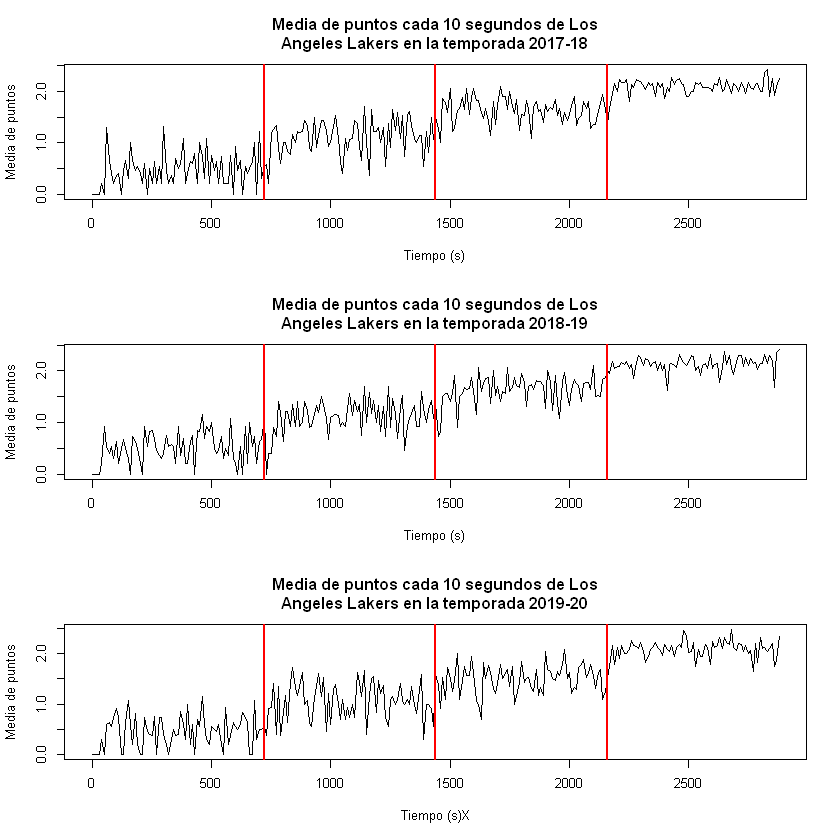

In [9]:
# jpeg("graphs\\time_series.jpg", width = 800, height = 500)

# Grid of plots (3 rows with 1 column)
par(mfrow = c(3, 1))

# Graph 1: 2017-18 Season
plot(df_means2017$Time, df_means2017$Media_Points, 
     type = "l", 
     main = "Media de puntos cada 10 segundos de Los\nAngeles Lakers en la temporada 2017-18", 
     xlab = "Tiempo (s)", ylab = "Media de puntos")
abline(v = c(720, 1440, 2160), col = "red", lwd = 2)

# Graph 2: 2018-19 Season
plot(df_means2018$Time, df_means2018$Media_Points, 
     type = "l", 
     main = "Media de puntos cada 10 segundos de Los\nAngeles Lakers en la temporada 2018-19", 
     xlab = "Tiempo (s)", ylab = "Media de puntos")
abline(v = c(720, 1440, 2160), col = "red", lwd = 2)

# Graph 3: 2019-20 Season
plot(df_means2019$Time, df_means2019$Media_Points, 
     type = "l", 
     main = "Media de puntos cada 10 segundos de Los\nAngeles Lakers en la temporada 2019-20", 
     xlab = "Tiempo (s)X", ylab = "Media de puntos")
abline(v = c(720, 1440, 2160), col = "red", lwd = 2)

# dev.off()

## Time Series Analysis

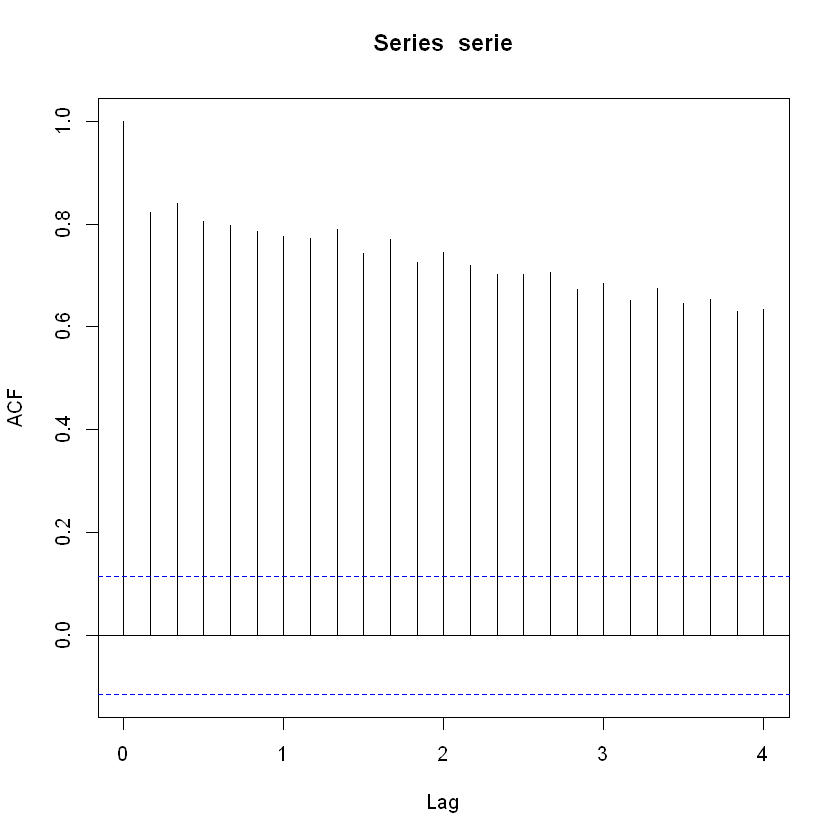

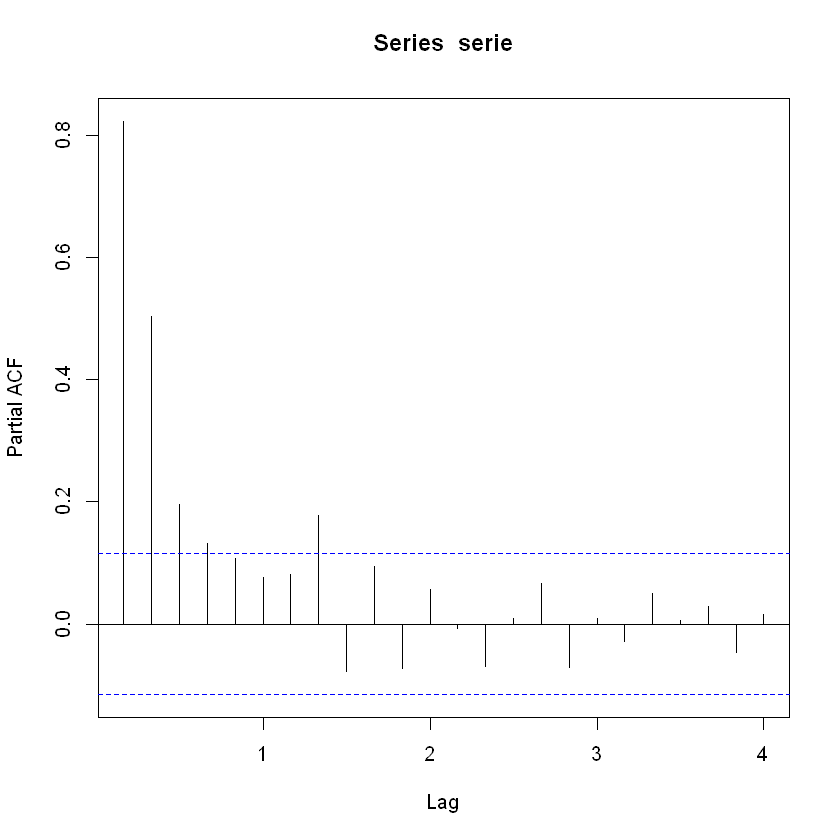

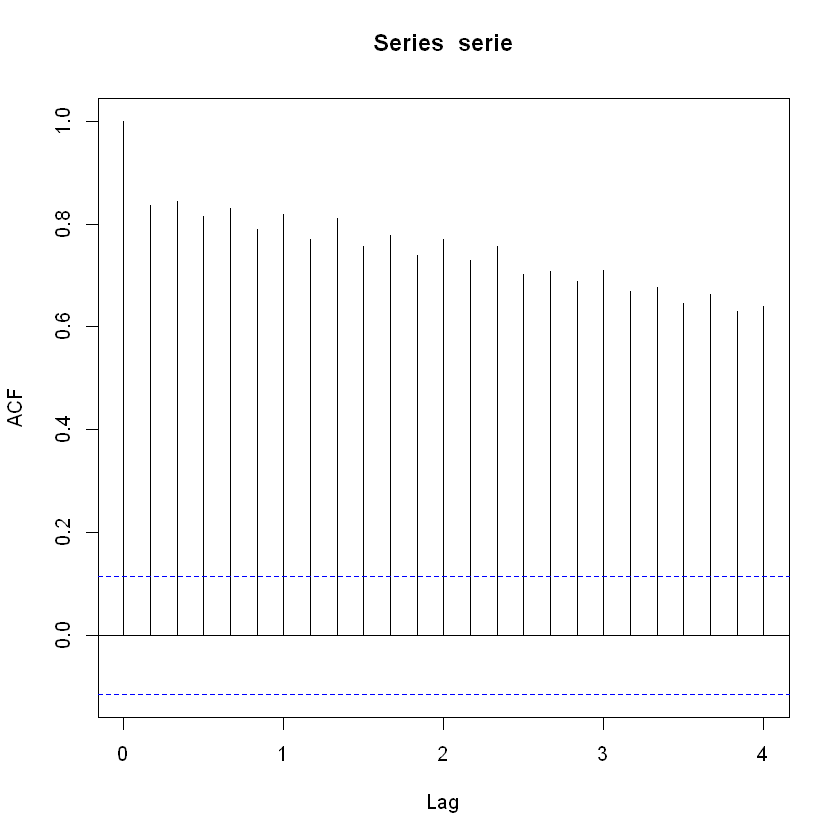

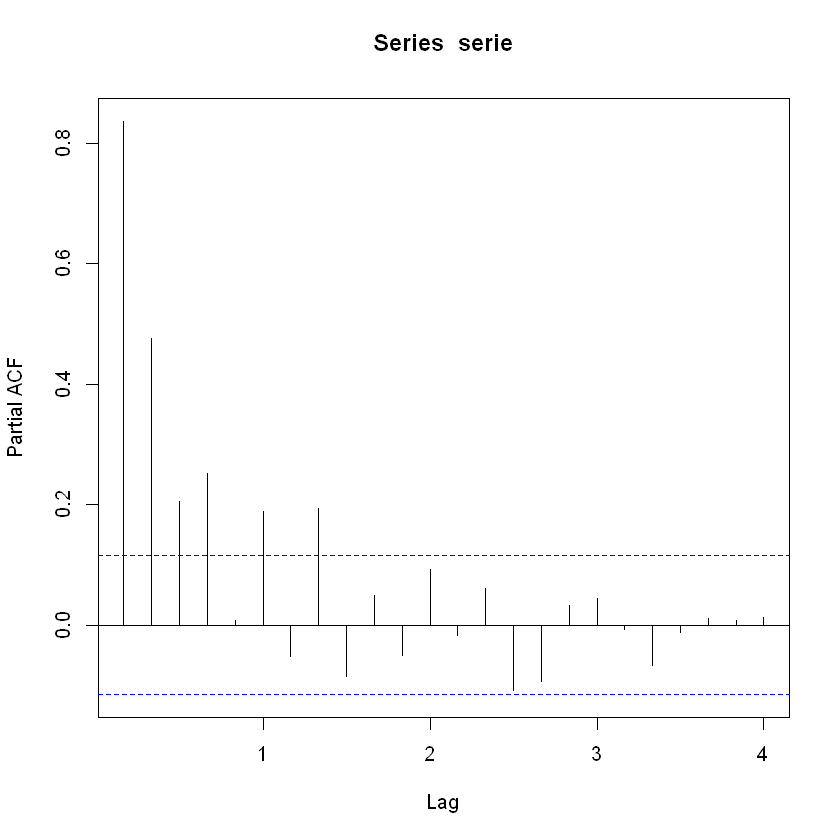

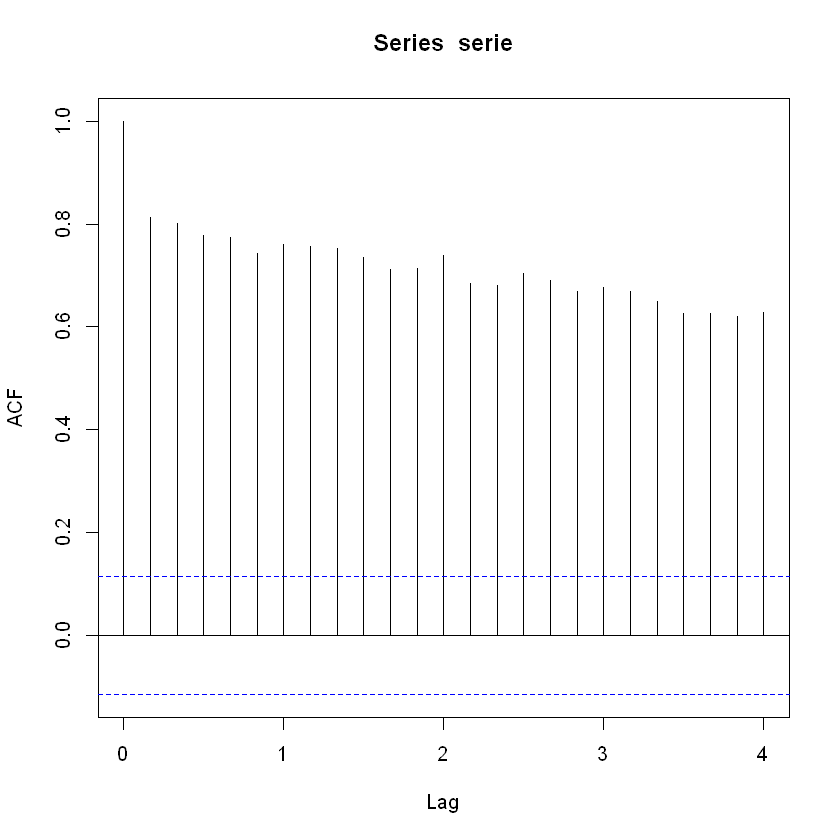

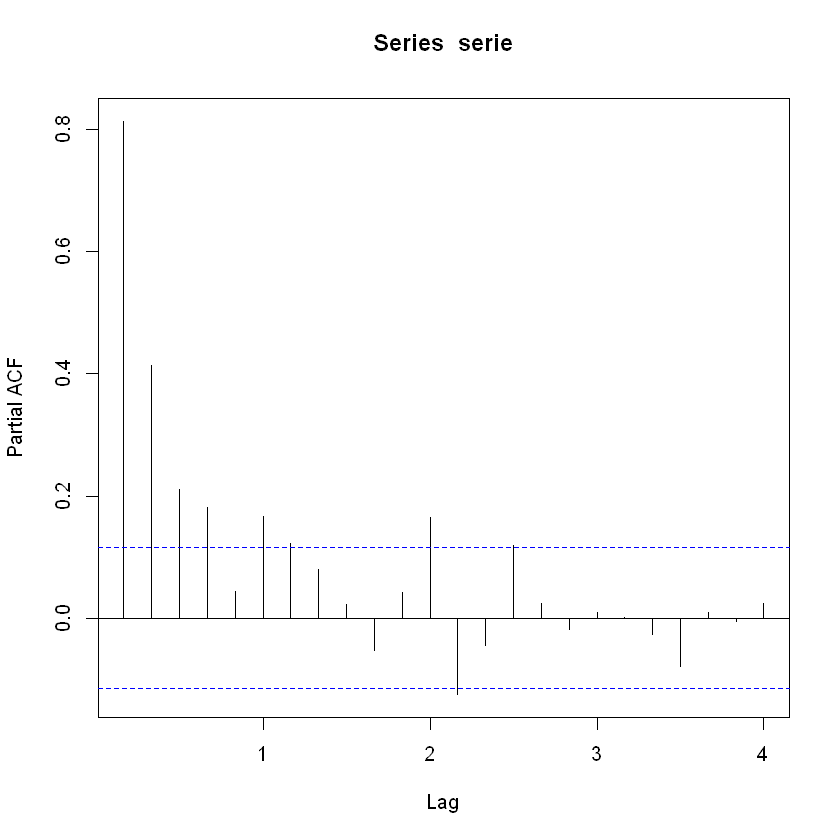

In [12]:
time_series_analysis <- function(df, freq = 6){
    
    # Use data as time series
    serie <- ts(df$Media_Points, frequency=freq)
    
    # Descompose a time series into seasonal, trend and errors
    descompose <- stl(serie, s.window='periodic')
    
    # Transform into time series object
    datats <- ts(rowSums(descompose$time.series))
    tsp(datats) <- tsp(descompose$time.series)
    
    #Break Detection in the Seasonal and Trend Component
    breaks <- bfast(datats, season="dummy", max.iter=3)
    
    # Create acf and pacf
    acf <- acf(serie)
    pacf <- pacf(serie)
    
    # Data to return 
    return_ <- list(descompose, breaks, acf, pacf)
    return (return_)
}

ts_2017 <- time_series_analysis(df_means2017)
descompose_2017 <- ts_2017[[1]]; breaks_2017 <- ts_2017[[2]]
acf_2017 <- ts_2017[[3]]; pacf_2017 <- ts_2017[[4]]

ts_2018 <- time_series_analysis(df_means2018)
descompose_2018 <- ts_2018[[1]]; breaks_2018 <- ts_2018[[2]]
acf_2018 <- ts_2018[[3]]; pacf_2018 <- ts_2018[[4]]

ts_2019 <- time_series_analysis(df_means2019)
descompose_2019 <- ts_2019[[1]]; breaks_2019 <- ts_2019[[2]]
acf_2019 <- ts_2019[[3]]; pacf_2019 <- ts_2019[[4]]


### Trend

Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4."


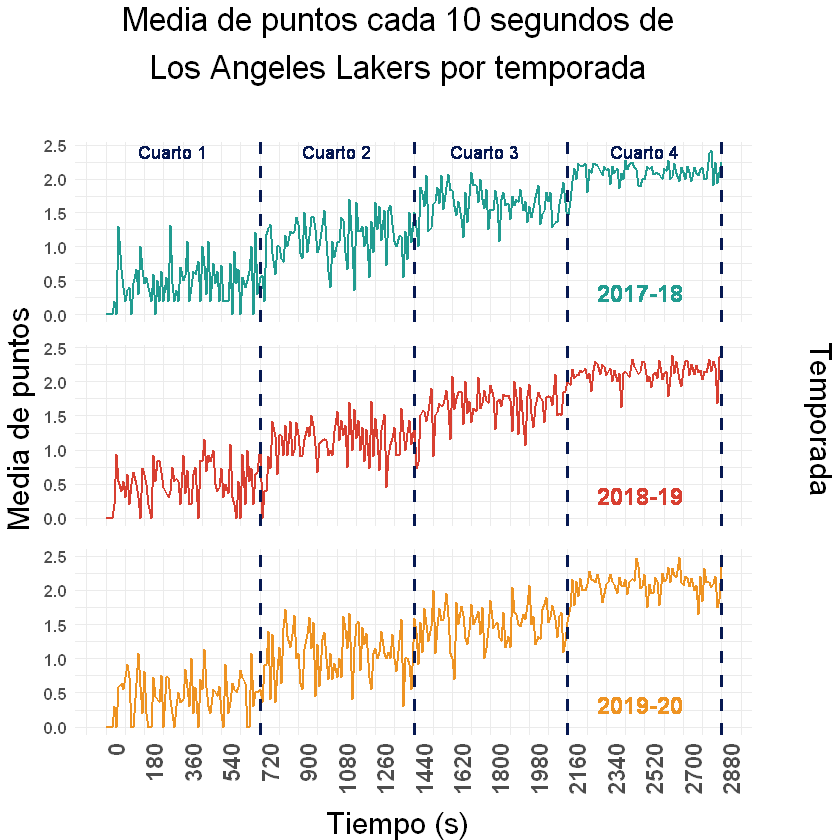

In [10]:
# Definir el data frame para las líneas verticales
vlines_data <- data.frame(xintercept = c(720, 1440, 2160, 2880),
                          season = c("Fin de\nCuarto 1", "Fin de\nCuarto 2", "Fin de\nCuarto 3", "Fin de\nCuarto 4"))

colors = c('#219C90', 
           '#D83F31', 
           '#E9B824', 
           '#EE9322')

# Crear los gráficos con las personalizaciones
p1 <- ggplot(df_means2017, aes(x = Time, y = Media_Points)) +
    geom_line(color = colors[1], lwd = 0.7) +
    geom_vline(data = vlines_data, aes(xintercept = xintercept, color = season), 
               linetype = "dashed", 
               lwd = 1, 
               color = '#071952') +
    labs(title = NULL, x = NULL, y = NULL) +
    scale_x_continuous(breaks = seq(0, 3000, by = 180)) +
    guides(color = FALSE) + 
    geom_text(aes(x = 2300, 
                   y = 0.2, 
                   label = '2017-18'), 
               size = 5, angle = 0, hjust = 0, color = colors[1], vjust = 0, fontface = "bold") +
     
    # Text about first quarter
    geom_text(aes(x = 150, 
                   y = 2.3, 
                   label = 'Cuarto 1'), 
               size = 3.8, angle = 0, hjust = 0, color = '#071952', vjust = 0) +

    # Text about second quarter
    geom_text(aes(x = 920, 
                   y = 2.3, 
                   label = 'Cuarto 2'), 
               size = 3.8, angle = 0, hjust = 0, color = '#071952', vjust = 0) +

    # Text about third quarter
    geom_text(aes(x = 1610, 
                   y = 2.3, 
                   label = 'Cuarto 3'), 
               size = 3.8, angle = 0, hjust = 0, color = '#071952', vjust = 0) +

    # Text about fourth quarter
    geom_text(aes(x = 2360, 
                   y = 2.3, 
                   label = 'Cuarto 4'), 
               size = 3.8, angle = 0, hjust = 0, color = '#071952', vjust = 0) +
    theme_minimal() +

    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

p2 <- ggplot(df_means2018, aes(x = Time, y = Media_Points)) +
    geom_line(color = colors[2], lwd = 0.7) +
    geom_vline(data = vlines_data, aes(xintercept = xintercept, color = season), 
               linetype = "dashed", 
               lwd = 1, 
               color = '#071952') +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
    scale_x_continuous(breaks = seq(0, 3000, by = 180)) +
    geom_text(aes(x = 2300, 
                   y = 0.2, 
                   label = '2018-19'), 
               size = 5, angle = 0, hjust = 0, color = colors[2], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

# Make graph in season 2019-20
p3 <- ggplot(df_means2019, aes(x = Time, y = Media_Points)) +
    geom_line(color = colors[4], lwd = 0.7) +
    geom_vline(data = vlines_data, aes(xintercept = xintercept, color = season), 
               linetype = "dashed", 
               lwd = 1, 
               color = '#071952') +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
    scale_x_continuous(breaks = seq(0, 3000, by = 180)) + 
    
    # Text about season
    geom_text(aes(x = 2300, 
                   y = 0.2, 
                   label = '2019-20'), 
               size = 5, angle = 0, hjust = 0, color = colors[4], vjust = 0, fontface = "bold") +
    
    theme_minimal() +
    theme(axis.text.x = element_text(size = 14, face = "bold", angle = 90, hjust = 1),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))


# Arrange the plots in a grid with custom margins
grid_arrange <- grid.arrange(
    p1, p2, p3,
    ncol = 1,
    heights = c(0.5, 0.5, 0.65),
    
    # Wirte left text
    left = textGrob("Media de puntos", rot = 90, 
                    gp = gpar(fontsize=18)),
    
    # Wirte bottom text
    bottom = textGrob("Tiempo (s)", gp=gpar(fontsize = 18)),
    
    # Wirte top text
    top = textGrob("Media de puntos cada 10 segundos de\nLos Angeles Lakers por temporada\n", rot = 0, 
                    gp = gpar(fontsize=20)), 
    
    # Wirte right text
    right = textGrob("Temporada\n", rot = 270, gp=gpar(fontsize = 18))
)

# Save fig
ggsave("graphs\\ts_lineplot.pdf", plot = arrangeGrob(grid_arrange), device = "pdf",
      width = 22, height = 16, units = "cm", dpi = 600)

### ACF

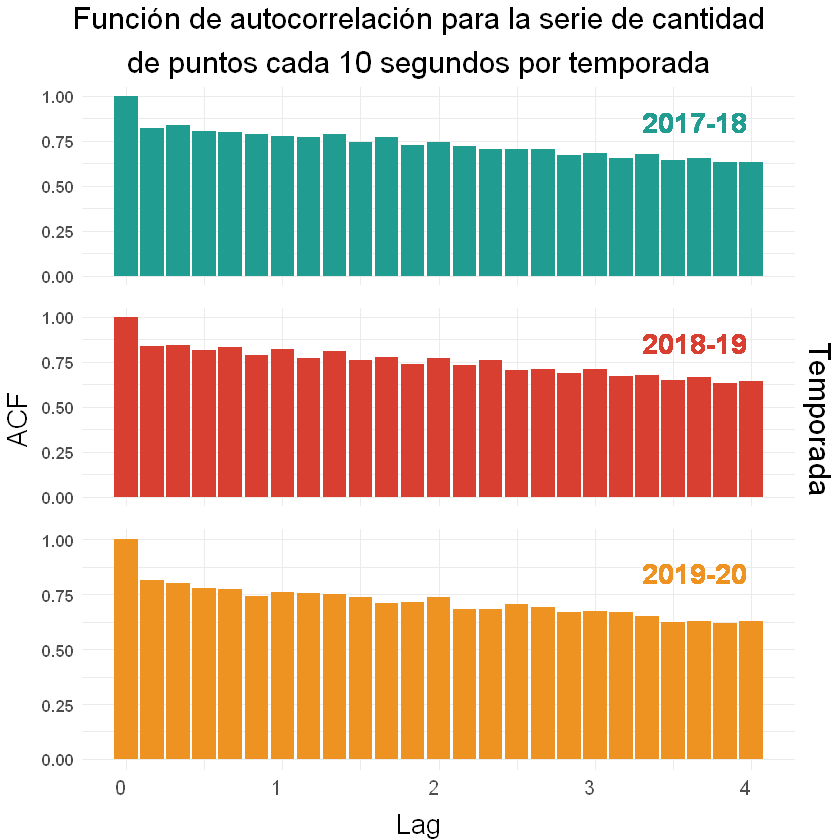

In [11]:
# Convierte el resultado de acf en un data frame
acf_data_2017 <- data.frame(lag = acf_2017$lag, acf = acf_2017$acf)
acf_data_2018 <- data.frame(lag = acf_2018$lag, acf = acf_2018$acf)
acf_data_2019 <- data.frame(lag = acf_2019$lag, acf = acf_2019$acf)

# Definir el data frame para las líneas verticales

colors = c('#219C90', 
           '#D83F31', 
           '#E9B824', 
           '#EE9322')

# Crear los gráficos con las personalizaciones
p1 <- ggplot(acf_data_2017, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[1]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.8, 
                   label = '2017-18'), 
               size = 6, angle = 0, hjust = 0, color = colors[1], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

p2 <- ggplot(acf_data_2018, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[2]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.8, 
                   label = '2018-19'), 
               size = 6, angle = 0, hjust = 0, color = colors[2], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

# Make graph in season 2019-20
p3 <- ggplot(acf_data_2019, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[4]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.8, 
                   label = '2019-20'), 
               size = 6, angle = 0, hjust = 0, color = colors[4], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 12, hjust = 1),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))


# Arrange the plots in a grid with custom margins
grid_arrange <- grid.arrange(
    p1, p2, p3,
    ncol = 1,
    heights = c(0.5, 0.5, 0.65),
    
    # Wirte left text
    left = textGrob("ACF", rot = 90, 
                    gp = gpar(fontsize=16)),
    
    # Wirte bottom text
    bottom = textGrob("Lag", gp=gpar(fontsize = 16)),
    
    # Wirte top text
    top = textGrob("Función de autocorrelación para la serie de cantidad\nde puntos cada 10 segundos por temporada", rot = 0, 
                    gp = gpar(fontsize=18)), 
    
    # Wirte right text
    right = textGrob("Temporada", rot = 270, gp=gpar(fontsize = 18))
)

# Save fig
ggsave("graphs\\acf.pdf", plot = arrangeGrob(grid_arrange), device = "pdf",
      width = 18, height = 16, units = "cm", dpi = 600)


### PACF

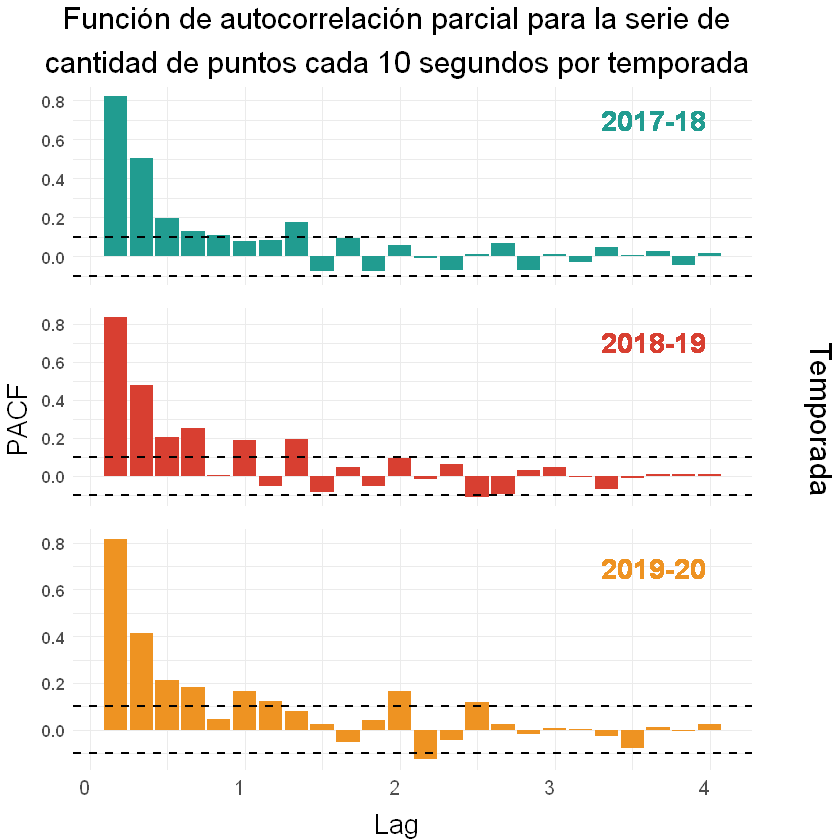

In [12]:
# Convierte el resultado de acf en un data frame
pacf_data_2017 <- data.frame(lag = pacf_2017$lag, acf = pacf_2017$acf)
pacf_data_2018 <- data.frame(lag = pacf_2018$lag, acf = pacf_2018$acf)
pacf_data_2019 <- data.frame(lag = pacf_2019$lag, acf = pacf_2019$acf)

# Definir el data frame para las líneas verticales

colors = c('#219C90', 
           '#D83F31', 
           '#E9B824', 
           '#EE9322')

# Crear los gráficos con las personalizaciones
p1 <- ggplot(pacf_data_2017, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[1]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.65, 
                   label = '2017-18'), 
               size = 6, angle = 0, hjust = 0, color = colors[1], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

p2 <- ggplot(pacf_data_2018, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[2]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.65, 
                   label = '2018-19'), 
               size = 6, angle = 0, hjust = 0, color = colors[2], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

# Make graph in season 2019-20
p3 <- ggplot(pacf_data_2019, aes(x = lag, y = acf)) +
    geom_bar(stat = "identity", fill = colors[4]) +
    labs(title = NULL, x = NULL, y = NULL) +
    guides(color = FALSE) + 
     geom_text(aes(x = 3.3, 
                   y = 0.65, 
                   label = '2019-20'), 
               size = 6, angle = 0, hjust = 0, color = colors[4], vjust = 0, fontface = "bold") +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 12, hjust = 1),  # Ángulo de las etiquetas x
          axis.text.y = element_text(size = 10, face = "bold"))

dashed_line <- geom_hline(yintercept = 0.10, linetype = "dashed", color = "black", lwd = 0.8)
dashed_line2 <- geom_hline(yintercept = -0.10, linetype = "dashed", color = "black", lwd = 0.8)

# Añadir la línea punteada a los gráficos
p1 <- p1 + dashed_line + dashed_line2  
p2 <- p2 + dashed_line + dashed_line2
p3 <- p3 + dashed_line + dashed_line2

# Arrange the plots in a grid with custom margins
grid_arrange <- grid.arrange(
    p1, p2, p3,
    ncol = 1,
    heights = c(0.5, 0.5, 0.65),
    
    # Wirte left text
    left = textGrob("PACF", rot = 90, 
                    gp = gpar(fontsize=16)),
    
    # Wirte bottom text
    bottom = textGrob("Lag", gp=gpar(fontsize = 16)),
    
    # Wirte top text
    top = textGrob("Función de autocorrelación parcial para la serie de\ncantidad de puntos cada 10 segundos por temporada", rot = 0, 
                    gp = gpar(fontsize=18)), 
    
    # Wirte right text
    right = textGrob("Temporada\n", rot = 270, gp=gpar(fontsize = 18))
)


ggsave("graphs\\pacf.pdf", plot = arrangeGrob(grid_arrange), device = "pdf",
      width = 18, height = 16, units = "cm", dpi = 600)

In [13]:
pdf("graphs\\descompose_2017.pdf", width = 10, height = 6)
plot(breaks_2017, main = "Descomposición de Serie temporal")
dev.off()


pdf("graphs\\descompose_2018.pdf", width = 10, height = 6)
plot(breaks_2018, main = "Descomposición de Serie temporal")
dev.off()


pdf("graphs\\descompose_2019.pdf", width = 10, height = 6)
plot(breaks_2019, main = "Descomposición de Serie temporal")
dev.off()


NULL

png 
  2

NULL

png 
  2

NULL

png 
  2

### Breaks

In [14]:
breaks_2017


  TREND BREAKPOINTS
	 Confidence intervals for breakpoints
	 of optimal 4-segment partition: 

Call:
confint.breakpointsfull(object = bp.Vt, het.err = FALSE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1    71          75     78
2   142         147    149
3   216         218    222

Corresponding to breakdates:
  2.5 % breakpoints 97.5 %
1 12(5) 13(3)       13(6) 
2 24(4) 25(3)       25(5) 
3 36(6) 37(2)       37(6) 

  SEASONAL BREAKPOINTS:  None


In [15]:
breaks_2018


  TREND BREAKPOINTS
	 Confidence intervals for breakpoints
	 of optimal 4-segment partition: 

Call:
confint.breakpointsfull(object = bp.Vt, het.err = FALSE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1    74          78     80
2   144         147    151
3   212         217    221

Corresponding to breakdates:
  2.5 % breakpoints 97.5 %
1 13(2) 13(6)       14(2) 
2 24(6) 25(3)       26(1) 
3 36(2) 37(1)       37(5) 

  SEASONAL BREAKPOINTS:  None


In [16]:
breaks_2019


  TREND BREAKPOINTS
	 Confidence intervals for breakpoints
	 of optimal 4-segment partition: 

Call:
confint.breakpointsfull(object = bp.Vt, het.err = FALSE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1    74          83     84
2   142         144    154
3   213         217    220

Corresponding to breakdates:
  2.5 % breakpoints 97.5 %
1 13(2) 14(5)       14(6) 
2 24(4) 24(6)       26(4) 
3 36(3) 37(1)       37(4) 

  SEASONAL BREAKPOINTS:  None


## ANOVA 

In [17]:
create_df_aov <- function (df){
    df %>%
        group_by(Year, URL) %>%
        summarize(
            Total_points = sum(Points, na.rm = FALSE),
        ) 
    }

In [52]:
df_aov_2017 <- create_df_aov(df_2017)
df_aov_2018 <- create_df_aov(df_2018)
df_aov_2019 <- create_df_aov(df_2019)


df_aov <- rbind(df_aov_2017, df_aov_2018)
df_aov <- rbind(df_aov, df_aov_2019)
df_aov$Total_points[df_aov$Total_points == 0] <- NA

df_aov <- na.omit(df_aov)

df_aov$Year <- as.factor(df_aov$Year)

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


In [61]:
Year_factor <- as.factor(df_aov$Year)

pdf("graphs\\box_aov.pdf", width = 10, height = 6)
boxplot(df_aov$Total_points~Year_factor,
        main = 'Total de puntos por temporada de Los Angeles Lakers',
        xlab = 'Año de inicio de temporada', 
        ylab = 'Total de puntos', 
        col=blues9)

dev.off()

png 
  2

### Modelo

In [53]:
anova_ = aov(Total_points ~ Year, data=df_aov)
summary(anova_)

             Df Sum Sq Mean Sq F value Pr(>F)  
Year          2    915   457.5    3.23 0.0413 *
Residuals   232  32864   141.7                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

### Residuales

In [95]:
e <- anova_$residuals

# Crear un dataframe con los residuos
data <- data.frame(Residuos = e)

# Crear el gráfico de caja utilizando ggplot2
p1 <- ggplot(data, aes(x = Residuos)) +
  geom_boxplot(fill = "#219C90", lwd = 1.2) +
  labs(
    title = "Boxplot de Residuos del Modelo ANOVA",
    y = "",
    x = "Residuos"
  ) +
 theme_minimal() + 
  theme(
    plot.title = element_text(size = 17, face = "bold"),  # Tamaño del título en negrita
    axis.title.y = element_blank(),
    axis.title.x = element_text(size = 15, face = "bold"),  # Tamaño del título del eje Y en negrita
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 12, face = "bold")   # Tamaño y negrita de los ticks del eje Y
  ) 

ggsave("graphs\\box_residuals.pdf", plot = p1, device = "pdf",
      width = 25, height = 10, units = "cm", dpi = 600)

#### Normalidad

In [55]:
shapiro.test(e)


	Shapiro-Wilk normality test

data:  e
W = 0.99497, p-value = 0.6328


#### Homocedasticidad

In [58]:
library(car)
leveneTest(e~Year, data = df_aov, center = "median")

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.7833182,0.458092
,232,NA,NA


### Post Anova

In [50]:
HSD.test(anova_,"Year",
         alpha=0.05, console=TRUE, group=FALSE)


Study: anova_ ~ "Year"

HSD Test for Total_points 

Mean Square Error:  141.8818 

Year,  means

     Total_points      std  r       se Min Max  Q25  Q50 Q75
2017     91.43902 11.99701 82 1.315395  65 118 85.0 90.5  99
2018     95.47561 11.39658 82 1.315395  69 124 87.5 96.0 103
2019     95.69014 12.35498 71 1.413625  67 124 87.0 98.0 105

Alpha: 0.05 ; DF Error: 233 
Critical Value of Studentized Range: 3.335833 

Comparison between treatments means

            difference pvalue signif.       LCL       UCL
2017 - 2018 -4.0365854 0.0786       . -8.424525 0.3513542
2017 - 2019 -4.2511165 0.0730       . -8.805842 0.3036088
2018 - 2019 -0.2145311 0.9932         -4.769256 4.3401942


In [ ]:
separateDF_by_quarter <- function(df){
    # Make first quarter dataframe
    df_firstQ <- df %>%
        filter(Time <= 720)
    
    # Make second quarter dataframe
    df_secondQ <- df %>%
        filter((Time > 720) & (Time <= 1440))
    
    # Make third quarter dataframe
    df_thirdQ <- df %>%
        filter((Time > 1440) & (Time <= 2160))
    
    # Make quarter quarter dataframe
    df_quarterQ <- df %>%
        filter((Time > 2160) & (Time <= 2880))
    
    # dataframes to return
    return_ <- list(df_firstQ, df_secondQ, df_thirdQ, df_quarterQ)
    
    return (return_)
}

In [ ]:
# Select all dataframes by quarter in each year
df_means2017_byQ <- separateDF_by_quarter(df_means2017)
df_means2018_byQ <- separateDF_by_quarter(df_means2018)
df_means2019_byQ <- separateDF_by_quarter(df_means2019)

# Make a single df from first Quarter in each year
df_Q1 <- rbind(data.frame(df_means2017_byQ[1]), data.frame(df_means2018_byQ[1]))
df_Q1 <- rbind(df_Q1, data.frame(df_means2019_byQ[1]))

# Make a single df from second Quarter in each year
df_Q2 <- rbind(data.frame(df_means2017_byQ[2]), data.frame(df_means2018_byQ[2]))
df_Q2 <- rbind(df_Q2, data.frame(df_means2019_byQ[2]))

# Make a single df from third Quarter in each year
df_Q3 <- rbind(data.frame(df_means2017_byQ[3]), data.frame(df_means2018_byQ[3]))
df_Q3 <- rbind(df_Q3, data.frame(df_means2019_byQ[3]))

# Make a single df from quarter Quarter in each year
df_Q4 <- rbind(data.frame(df_means2017_byQ[4]), data.frame(df_means2018_byQ[4]))
df_Q4 <- rbind(df_Q4, data.frame(df_means2019_byQ[4]))
